# Ben Bettencourt and Assoumer Redempta Manzi Muneza
## Final Project
### NLP Spring 2023

Goal: look for potential trends that might help understanding of why certain results are clicked. Further, can we predict which result a child will click on?

To achieve this:
- This Notebook
-- Load child query data
-- Assign 0 to results that were shown to the user but weren't clicked on (negative examples)
-- Assign 1 to the results that were clicked on (positive examples)
- Features Notbook
-- Define and extract features from query snippets
-- Train and evaluate a binary classifier using these features and labels

#### Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import json
import nltk

red = '/content/drive/MyDrive/ a Spring 2023/NLP/Final Project/dump/'
ben = '/content/drive/MyDrive/NLP/Final Project/dump/'

In [3]:
#### Change the path for whichever person is currently working on this :) ###
path = ben
#path = red

#### Prep Data

In [4]:
event_type = pd.read_csv(path + 'castdb_event_type.csv', header=None,names=['etid','event_type'])

event_type.head(30)

,etid,event_type
0,1,keystroke
1,2,click
2,3,hover misspelled word
3,4,hover spelling suggestion
4,5,click spelling suggestion
5,6,query
6,7,selection
7,8,popup
8,9,click result
9,10,hover result


In [5]:
clean_events = pd.read_csv(path + 'clean_event.csv')
ces = clean_events['event_id']
ces

0         26570
1         26572
2         26575
3         26875
4         26878
          ...  
77707    189300
77708    189307
77709    189308
77710    189310
77711    189311
Name: event_id, Length: 77712, dtype: int64

In [6]:
event = pd.read_csv(path + 'castdb_event.tsv', sep="\t", na_values=['\\N'],header=None, names= ['eid','sid','qid','event_created','etid','event','event_data','event_num'])
event

,eid,sid,qid,event_created,etid,event,event_data,event_num
0,1,1,NaN,1558334318377,18,en-img-init,{enableImages: 1},NaN
1,2,1,NaN,1558334318380,18,en-voice-init,{enableVoice: 1},NaN
2,3,1,d119db54-90aa-48b3-9035-eeda55edc38d,1558334320030,18,init config for new qid,"{\imgConfig\"":1,\""vceConfig\"":1}""",NaN
3,4,1,d119db54-90aa-48b3-9035-eeda55edc38d,1558334320180,1,keystroke,"{\key\"":\""h\""}""",NaN
4,5,1,d119db54-90aa-48b3-9035-eeda55edc38d,1558334320219,16,input-parsed,"{\misspelled_words\"":[]}""",NaN
...,...,...,...,...,...,...,...,...
192880,197152,19545,9b536244-99e9-423d-b988-72baf046a2be,1638789092823,10,hov-result,"{\hovered\"":\""8\""}""",63.0
192881,197153,19545,9b536244-99e9-423d-b988-72baf046a2be,1638789093235,10,hov-result,"{\hovered\"":\""7\""}""",65.0
192882,197154,19545,9b536244-99e9-423d-b988-72baf046a2be,1638789093263,14,hov-off-result,"{\hovered\"":\""8\""}""",64.0
192883,197155,19545,9b536244-99e9-423d-b988-72baf046a2be,1638789093533,14,hov-off-result,"{\hovered\"":\""7\""}""",66.0


In [7]:
event = pd.merge(event,event_type)#, on='etid')
event.head()

,eid,sid,qid,event_created,etid,event,event_data,event_num,event_type
0,1,1,NaN,1558334318377,18,en-img-init,{enableImages: 1},NaN,config variable initialized
1,2,1,NaN,1558334318380,18,en-voice-init,{enableVoice: 1},NaN,config variable initialized
2,3,1,d119db54-90aa-48b3-9035-eeda55edc38d,1558334320030,18,init config for new qid,"{\imgConfig\"":1,\""vceConfig\"":1}""",NaN,config variable initialized
3,88,2,NaN,1558366500359,18,en-img-init,{enableImages: 1},NaN,config variable initialized
4,89,2,NaN,1558366500373,18,en-voice-init,{enableVoice: 1},NaN,config variable initialized


In [8]:
clicked = event[event['event_type'] == 'click result']
clicked

,eid,sid,qid,event_created,etid,event,event_data,event_num,event_type
189576,86,1,d119db54-90aa-48b3-9035-eeda55edc38d,1558334344624,9,clk-result,"{\position\"":0}""",NaN,click result
189577,141,2,df763da0-ca3a-4d53-a7a9-63e4c9983f51,1558366547959,9,clk-result,"{\position\"":1}""",NaN,click result
189578,162,2,df763da0-ca3a-4d53-a7a9-63e4c9983f51,1558366615476,9,clk-result,"{\position\"":1}""",NaN,click result
189579,233,4,19e1e94f-4c71-4b5a-8a24-3e1bb4484084,1558366837091,9,clk-result,"{\position\"":0}""",NaN,click result
189580,347,4,a4d01dc1-7365-4788-ae99-bdbcdea2b578,1558366864972,9,clk-result,"{\position\"":0}""",NaN,click result
...,...,...,...,...,...,...,...,...,...
190564,195373,17595,fe57e331-9d9a-41c1-ba1e-fb4f43f1d472,1634841220212,9,clk-result,"{\position\"":\""1\""}""",47.0,click result
190565,195450,17636,e0403d46-142a-43ab-9f04-f4493b582158,1634920289763,9,clk-result,"{\position\"":\""0\""}""",29.0,click result
190566,195779,18334,4a2a23a2-386f-4f86-8d10-aa964a2885b4,1636386082424,9,clk-result,"{\position\"":\""0\""}""",50.0,click result
190567,195955,18701,bd405902-b414-4e3d-8850-f938663e9f43,1637098141421,9,clk-result,"{\position\"":\""0\""}""",103.0,click result


In [9]:
p = clicked['event_data']
p_clean = p.apply(lambda x: json.loads("{}\"{}".format(x[:2], x[2:-1]).replace("\\","")))
pos = p_clean.apply(lambda x: int(x['position']))
pos

189576    0
189577    1
189578    1
189579    0
189580    0
         ..
190564    1
190565    0
190566    0
190567    0
190568    1
Name: event_data, Length: 993, dtype: int64

In [10]:
clicked['pos'] = pos
clicked

<ipython-input-10-33c5f280cb16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicked['pos'] = pos


,eid,sid,qid,event_created,etid,event,event_data,event_num,event_type,pos
189576,86,1,d119db54-90aa-48b3-9035-eeda55edc38d,1558334344624,9,clk-result,"{\position\"":0}""",NaN,click result,0
189577,141,2,df763da0-ca3a-4d53-a7a9-63e4c9983f51,1558366547959,9,clk-result,"{\position\"":1}""",NaN,click result,1
189578,162,2,df763da0-ca3a-4d53-a7a9-63e4c9983f51,1558366615476,9,clk-result,"{\position\"":1}""",NaN,click result,1
189579,233,4,19e1e94f-4c71-4b5a-8a24-3e1bb4484084,1558366837091,9,clk-result,"{\position\"":0}""",NaN,click result,0
189580,347,4,a4d01dc1-7365-4788-ae99-bdbcdea2b578,1558366864972,9,clk-result,"{\position\"":0}""",NaN,click result,0
...,...,...,...,...,...,...,...,...,...,...
190564,195373,17595,fe57e331-9d9a-41c1-ba1e-fb4f43f1d472,1634841220212,9,clk-result,"{\position\"":\""1\""}""",47.0,click result,1
190565,195450,17636,e0403d46-142a-43ab-9f04-f4493b582158,1634920289763,9,clk-result,"{\position\"":\""0\""}""",29.0,click result,0
190566,195779,18334,4a2a23a2-386f-4f86-8d10-aa964a2885b4,1636386082424,9,clk-result,"{\position\"":\""0\""}""",50.0,click result,0
190567,195955,18701,bd405902-b414-4e3d-8850-f938663e9f43,1637098141421,9,clk-result,"{\position\"":\""0\""}""",103.0,click result,0


In [11]:
click_qid = clicked['qid']

In [12]:
tot_result = pd.read_csv(path + 'castdb_result.tsv', sep='\t', na_values=['\\N'], header=None,names=['rid','qid','title','snippet','url','pos','image'])
tot_result.head(3)

,rid,qid,title,snippet,url,pos,image
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,NaN
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,NaN
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,NaN


In [13]:
results = tot_result[tot_result['qid'].isin(click_qid)]
results

,rid,qid,title,snippet,url,pos,image
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,NaN
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,NaN
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,NaN
3,4,d119db54-90aa-48b3-9035-eeda55edc38d,College Scholarships - Scholarships.com,Most college scholarships target incoming fres...,https://www.scholarships.com/financial-aid/col...,3,NaN
4,5,d119db54-90aa-48b3-9035-eeda55edc38d,How to start sending email — Mailgun API docum...,"It's up to you, whatever you find easier is fi...",http://documentation.mailgun.com/en/latest/qui...,2,NaN
...,...,...,...,...,...,...,...
26376,26377,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,"Science, Technology, Engineering, and Math, in...",Department Offices that Support STEM Open ED F...,https://www.ed.gov/stem,1,https://encrypted-tbn0.gstatic.com/images?q=tb...
26377,26378,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Kitchen SF,STEM Kitchen & Garden is a farm-to-table resta...,https://www.stemkitchensf.com/,6,http://static1.squarespace.com/static/549322ba...
26378,26379,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Definition & Meaning - Merriam-Webster,Kids Definition of stem 1 : to develop as a c...,https://www.merriam-webster.com/dictionary/stem,7,https://merriam-webster.com/assets/mw/static/s...
26379,26380,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Driven By Stem,Stem Holdings has positioned itself as a leade...,https://www.drivenbystem.com/,8,http://static1.squarespace.com/static/5820a80b...


In [14]:
results['clicked'] = 0
results

<ipython-input-14-703c45be7fd1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['clicked'] = 0


,rid,qid,title,snippet,url,pos,image,clicked
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,NaN,0
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,NaN,0
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,NaN,0
3,4,d119db54-90aa-48b3-9035-eeda55edc38d,College Scholarships - Scholarships.com,Most college scholarships target incoming fres...,https://www.scholarships.com/financial-aid/col...,3,NaN,0
4,5,d119db54-90aa-48b3-9035-eeda55edc38d,How to start sending email — Mailgun API docum...,"It's up to you, whatever you find easier is fi...",http://documentation.mailgun.com/en/latest/qui...,2,NaN,0
...,...,...,...,...,...,...,...,...
26376,26377,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,"Science, Technology, Engineering, and Math, in...",Department Offices that Support STEM Open ED F...,https://www.ed.gov/stem,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,0
26377,26378,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Kitchen SF,STEM Kitchen & Garden is a farm-to-table resta...,https://www.stemkitchensf.com/,6,http://static1.squarespace.com/static/549322ba...,0
26378,26379,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Definition & Meaning - Merriam-Webster,Kids Definition of stem 1 : to develop as a c...,https://www.merriam-webster.com/dictionary/stem,7,https://merriam-webster.com/assets/mw/static/s...,0
26379,26380,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Driven By Stem,Stem Holdings has positioned itself as a leade...,https://www.drivenbystem.com/,8,http://static1.squarespace.com/static/5820a80b...,0


In [15]:
full = pd.merge(results, clicked, how='left', on=['qid', 'pos'])
full

,rid,qid,title,snippet,url,pos,image,clicked,eid,sid,event_created,etid,event,event_data,event_num,event_type
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,NaN,0,86.0,1.0,1.558334e+12,9.0,clk-result,"{\position\"":0}""",NaN,click result
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,d119db54-90aa-48b3-9035-eeda55edc38d,College Scholarships - Scholarships.com,Most college scholarships target incoming fres...,https://www.scholarships.com/financial-aid/col...,3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,d119db54-90aa-48b3-9035-eeda55edc38d,How to start sending email — Mailgun API docum...,"It's up to you, whatever you find easier is fi...",http://documentation.mailgun.com/en/latest/qui...,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10287,26377,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,"Science, Technology, Engineering, and Math, in...",Department Offices that Support STEM Open ED F...,https://www.ed.gov/stem,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,0,197078.0,19413.0,1.638515e+12,9.0,clk-result,"{\position\"":\""1\""}""",49.0,click result
10288,26378,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Kitchen SF,STEM Kitchen & Garden is a farm-to-table resta...,https://www.stemkitchensf.com/,6,http://static1.squarespace.com/static/549322ba...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10289,26379,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Definition & Meaning - Merriam-Webster,Kids Definition of stem 1 : to develop as a c...,https://www.merriam-webster.com/dictionary/stem,7,https://merriam-webster.com/assets/mw/static/s...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10290,26380,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Driven By Stem,Stem Holdings has positioned itself as a leade...,https://www.drivenbystem.com/,8,http://static1.squarespace.com/static/5820a80b...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#### This cell will mark any click result with 1 (true)####
full.loc[full['event_type'] == 'click result', 'clicked'] = 1
full

,rid,qid,title,snippet,url,pos,image,clicked,eid,sid,event_created,etid,event,event_data,event_num,event_type
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,NaN,1,86.0,1.0,1.558334e+12,9.0,clk-result,"{\position\"":0}""",NaN,click result
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,d119db54-90aa-48b3-9035-eeda55edc38d,College Scholarships - Scholarships.com,Most college scholarships target incoming fres...,https://www.scholarships.com/financial-aid/col...,3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,d119db54-90aa-48b3-9035-eeda55edc38d,How to start sending email — Mailgun API docum...,"It's up to you, whatever you find easier is fi...",http://documentation.mailgun.com/en/latest/qui...,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10287,26377,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,"Science, Technology, Engineering, and Math, in...",Department Offices that Support STEM Open ED F...,https://www.ed.gov/stem,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,1,197078.0,19413.0,1.638515e+12,9.0,clk-result,"{\position\"":\""1\""}""",49.0,click result
10288,26378,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Kitchen SF,STEM Kitchen & Garden is a farm-to-table resta...,https://www.stemkitchensf.com/,6,http://static1.squarespace.com/static/549322ba...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10289,26379,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Definition & Meaning - Merriam-Webster,Kids Definition of stem 1 : to develop as a c...,https://www.merriam-webster.com/dictionary/stem,7,https://merriam-webster.com/assets/mw/static/s...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10290,26380,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Driven By Stem,Stem Holdings has positioned itself as a leade...,https://www.drivenbystem.com/,8,http://static1.squarespace.com/static/5820a80b...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
full['full'] = 'default'
for i in range(len(full['title'])):
  full['full'][i] = str(full['title'][i]) + str(full['snippet'][i])
full

<ipython-input-17-631cb0f266bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full['full'][i] = str(full['title'][i]) + str(full['snippet'][i])


,rid,qid,title,snippet,url,pos,image,clicked,eid,sid,event_created,etid,event,event_data,event_num,event_type,full
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,NaN,1,86.0,1.0,1.558334e+12,9.0,clk-result,"{\position\"":0}""",NaN,click result,Incoming Webhooks — Mattermost 5.11 documentat...
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,“Hello” Is Facebook's New Android-Only Social ...
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walkthrough | HTTP Event CollectorHEC tokens a...
3,4,d119db54-90aa-48b3-9035-eeda55edc38d,College Scholarships - Scholarships.com,Most college scholarships target incoming fres...,https://www.scholarships.com/financial-aid/col...,3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College Scholarships - Scholarships.comMost co...
4,5,d119db54-90aa-48b3-9035-eeda55edc38d,How to start sending email — Mailgun API docum...,"It's up to you, whatever you find easier is fi...",http://documentation.mailgun.com/en/latest/qui...,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,How to start sending email — Mailgun API docum...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10287,26377,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,"Science, Technology, Engineering, and Math, in...",Department Offices that Support STEM Open ED F...,https://www.ed.gov/stem,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,1,197078.0,19413.0,1.638515e+12,9.0,clk-result,"{\position\"":\""1\""}""",49.0,click result,"Science, Technology, Engineering, and Math, in..."
10288,26378,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Kitchen SF,STEM Kitchen & Garden is a farm-to-table resta...,https://www.stemkitchensf.com/,6,http://static1.squarespace.com/static/549322ba...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stem Kitchen SFSTEM Kitchen & Garden is a farm...
10289,26379,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Definition & Meaning - Merriam-Webster,Kids Definition of stem 1 : to develop as a c...,https://www.merriam-webster.com/dictionary/stem,7,https://merriam-webster.com/assets/mw/static/s...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stem Definition & Meaning - Merriam-WebsterKid...
10290,26380,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Driven By Stem,Stem Holdings has positioned itself as a leade...,https://www.drivenbystem.com/,8,http://static1.squarespace.com/static/5820a80b...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Driven By StemStem Holdings has positioned its...


In [18]:
#### Dropping some columns that I don't think we'll need ####
full_clean = full.drop(columns=['image', 'eid','sid','event_created', 'event_num', 'etid'])
full_clean = full_clean.reset_index(drop=True)
full_clean 

,rid,qid,title,snippet,url,pos,clicked,event,event_data,event_type,full
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,1,clk-result,"{\position\"":0}""",click result,Incoming Webhooks — Mattermost 5.11 documentat...
1,2,d119db54-90aa-48b3-9035-eeda55edc38d,“Hello” Is Facebook's New Android-Only Social ...,"Apr 22, 2015 ... Today, Hello is rolling out f...",https://techcrunch.com/2015/04/22/facebook-hello/,1,0,NaN,NaN,NaN,“Hello” Is Facebook's New Android-Only Social ...
2,3,d119db54-90aa-48b3-9035-eeda55edc38d,Walkthrough | HTTP Event Collector,HEC tokens are sent in the headers of incoming...,http://dev.splunk.com/view/event-collector/SP-...,4,0,NaN,NaN,NaN,Walkthrough | HTTP Event CollectorHEC tokens a...
3,4,d119db54-90aa-48b3-9035-eeda55edc38d,College Scholarships - Scholarships.com,Most college scholarships target incoming fres...,https://www.scholarships.com/financial-aid/col...,3,0,NaN,NaN,NaN,College Scholarships - Scholarships.comMost co...
4,5,d119db54-90aa-48b3-9035-eeda55edc38d,How to start sending email — Mailgun API docum...,"It's up to you, whatever you find easier is fi...",http://documentation.mailgun.com/en/latest/qui...,2,0,NaN,NaN,NaN,How to start sending email — Mailgun API docum...
...,...,...,...,...,...,...,...,...,...,...,...
10287,26377,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,"Science, Technology, Engineering, and Math, in...",Department Offices that Support STEM Open ED F...,https://www.ed.gov/stem,1,1,clk-result,"{\position\"":\""1\""}""",click result,"Science, Technology, Engineering, and Math, in..."
10288,26378,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Kitchen SF,STEM Kitchen & Garden is a farm-to-table resta...,https://www.stemkitchensf.com/,6,0,NaN,NaN,NaN,Stem Kitchen SFSTEM Kitchen & Garden is a farm...
10289,26379,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Stem Definition & Meaning - Merriam-Webster,Kids Definition of stem 1 : to develop as a c...,https://www.merriam-webster.com/dictionary/stem,7,0,NaN,NaN,NaN,Stem Definition & Meaning - Merriam-WebsterKid...
10290,26380,73308e25-c3e2-4fd6-ac7c-91a88c2b6c41,Driven By Stem,Stem Holdings has positioned itself as a leade...,https://www.drivenbystem.com/,8,0,NaN,NaN,NaN,Driven By StemStem Holdings has positioned its...


In [19]:
len(pd.unique(full_clean['qid']))

633

In [ ]:
### Export the clean data for feature extraction
full_clean.to_csv('final_results_data.csv')

In [ ]:
pwd

'/content'

The 'full_clean' dataframe should now have everything we need:
- Title of result: 'title'
- Snippet from result: 'snippet'
- Position of result on SERP: 'pos' (0=top of page, 9=bottom of page)
- Was this result clicked or not: 'clicked' (0=not clicked, 1=clicked)

#### Feature Extraction

In [ ]:
nltk.download('brown')
nltk.download('punkt')
nltk.download('tagsets')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
from nltk.corpus import brown

##### 'tagger' is a combination tagger. When trying to tag a word, the tagger will try tagging by using the basic HMM from nltk. If that tagger is unable to tag a word, it will default to a TrigramTagger. If that tagger is unable to tag a word, it will default to a BigramTagger. If that tagger is unable to tag a word, it will default to a UnigramTagger. Finally, if that tagger fails to tag a word, the word in question will be tagged 'NN'.

In [ ]:
t0 = nltk.DefaultTagger('default')
t1 = nltk.UnigramTagger(brown.tagged_sents(), backoff=t0)
t2 = nltk.BigramTagger(brown.tagged_sents(), backoff=t1)
t3 = nltk.TrigramTagger(brown.tagged_sents(), backoff=t2)
#tagger = nltk.HiddenMarkovModelTagger.train(brown.tagged_sents(), backoff=t3)
tagger = t3

In [ ]:
tagger.accuracy(brown.tagged_sents())

0.970352017581933

In [ ]:
full_clean['tags'] = full_clean.apply(lambda row: tagger.tag(nltk.word_tokenize(str(row.full))), axis=1)
#full_clean['snippet_tags'] = full_clean.apply(lambda row: tagger.tag(nltk.word_tokenize(str(row.snippet))), axis=1)
#full_clean['title_tags'] = full_clean.apply(lambda row: tagger.tag(nltk.word_tokenize(str(row.title))), axis=1)

#### Frequency of Tags for Titles and Snippets

In [ ]:
total = 0
tagFD = nltk.FreqDist()
for row in full_clean['tags']:
  for word, tag in row:
    tagFD[tag] +=1
    total +=1
tagFD.pop('default')
tagFD.most_common()

[('NN-TL', 164672),
 ('NN', 123504),
 ('CD', 113212),
 (',', 113212),
 ('IN', 82336),
 ('VB', 61752),
 (':', 61752),
 ('JJ-TL', 51460),
 ('BEZ', 41168),
 ('AT', 41168),
 ('TO', 30876),
 ('VBN', 30876),
 ('JJ', 30876),
 ('NNS', 30876),
 ('UH', 20584),
 ('VBG', 20584),
 ('NN-HL', 20584),
 ('CC-TL', 20584),
 ('NNS-TL', 20584),
 ('NP', 20584),
 ('RP', 20584),
 ('CS', 20584),
 ('CD-TL', 10292),
 ('WRB', 10292),
 ('CC', 10292),
 ('RB', 10292),
 ('NR', 10292),
 ('BER', 10292),
 ('AP', 10292),
 ('PPS', 10292),
 ('PPO', 10292),
 ('WDT', 10292),
 ('PPSS', 10292),
 ('JJR', 10292),
 ('WPS', 10292),
 ('IN-HL', 10292),
 ('.', 10292),
 ('HVZ', 10292),
 ('PPL', 10292)]

In [ ]:
tagFD.most_common(1)[0][1] / total

0.07692307692307693

#### Below is the tagset that the brown corpus uses:

NOTES: 
- the -TL suffix denotes the given word was in the title
- the -HL suffix denotes the given word was in the header

In [ ]:
nltk.help.brown_tagset()

(: opening parenthesis
    (
): closing parenthesis
    )
*: negator
    not n't
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ? ; ! :
:: colon
    :
ABL: determiner/pronoun, pre-qualifier
    quite such rather
ABN: determiner/pronoun, pre-quantifier
    all half many nary
ABX: determiner/pronoun, double conjunction or pre-quantifier
    both
AP: determiner/pronoun, post-determiner
    many other next more last former little several enough most least only
    very few fewer past same Last latter less single plenty 'nough lesser
    certain various manye next-to-last particular final previous present
    nuf
AP$: determiner/pronoun, post-determiner, genitive
    other's
AP+AP: determiner/pronoun, post-determiner, hyphenated pair
    many-much
AT: article
    the an no a every th' ever' ye
BE: verb 'to be', infinitive or imperative
    be
BED: verb 'to be', past tense, 2nd person singular or all persons plural
    were
BED*: verb 'to be', past tense, 2nd person singular or 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 [Text(0, 0, 'NN-TL'),
  Text(1, 0, 'NN'),
  Text(2, 0, 'CD'),
  Text(3, 0, ','),
  Text(4, 0, 'IN'),
  Text(5, 0, 'VB'),
  Text(6, 0, ':'),
  Text(7, 0, 'JJ-TL'),
  Text(8, 0, 'BEZ'),
  Text(9, 0, 'AT'),
  Text(10, 0, 'TO'),
  Text(11, 0, 'VBN'),
  Text(12, 0, 'JJ'),
  Text(13, 0, 'NNS'),
  Text(14, 0, 'UH'),
  Text(15, 0, 'VBG'),
  Text(16, 0, 'NN-HL'),
  Text(17, 0, 'CC-TL'),
  Text(18, 0, 'NNS-TL'),
  Text(19, 0, 'NP'),
  Text(20, 0, 'RP'),
  Text(21, 0, 'CS'),
  Text(22, 0, 'CD-TL'),
  Text(23, 0, 'WRB'),
  Text(24, 0, 'CC'),
  Text(25, 0, 'RB'),
  Text(26, 0, 'NR'),
  Text(27, 0, 'BER'),
  Text(28, 0, 'AP'),
  Text(29, 0, 'PPS'),
  Text(30, 0, 'PPO'),
  Text(31, 0, 'WDT'),
  Text(32, 0, 'PPSS'),
  Text(33, 0, 'JJR'),
  Text(34, 0, 'WPS'),
  Text(35, 0, 'IN-HL'),
  Text(36, 0, '.'),
  Text(37, 0, 'HVZ'

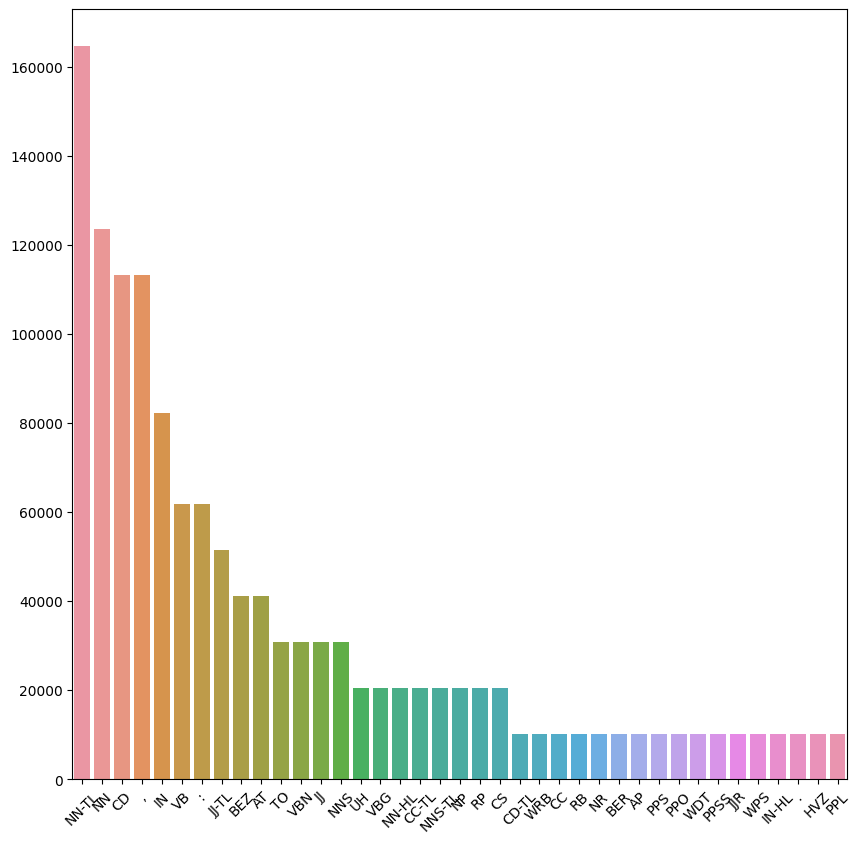

In [ ]:
fd_most_common =  tagFD.most_common()
fdmc = pd.Series(dict(fd_most_common))
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.barplot(x=fdmc.index, y=fdmc.values, ax=ax)
plt.xticks(rotation=45)

In [ ]:
cClicked = full_clean[full_clean['clicked']==1]
cClicked = cClicked.reset_index(drop=True)
cClicked

,rid,qid,title,snippet,url,pos,clicked,event,event_data,event_type,full,tags
0,1,d119db54-90aa-48b3-9035-eeda55edc38d,Incoming Webhooks — Mattermost 5.11 documentation,Use incoming webhooks to post messages to Matt...,https://docs.mattermost.com/developer/webhooks...,0,1,clk-result,"{\position\"":0}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
1,22,df763da0-ca3a-4d53-a7a9-63e4c9983f51,Iran Facts for Kids,"Apr 9, 2019 ... In the past, Iran was called \...",https://kids.kiddle.co/Iran,1,1,clk-result,"{\position\"":1}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
2,22,df763da0-ca3a-4d53-a7a9-63e4c9983f51,Iran Facts for Kids,"Apr 9, 2019 ... In the past, Iran was called \...",https://kids.kiddle.co/Iran,1,1,clk-result,"{\position\"":1}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
3,31,19e1e94f-4c71-4b5a-8a24-3e1bb4484084,Norway - Wikipedia,"Norway officially the Kingdom of Norway, is a ...",https://en.wikipedia.org/wiki/Norway,0,1,clk-result,"{\position\"":0}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
4,50,8363cc6e-4b22-48b7-85f1-d2aa51a87e22,Geography for Kids: Iran,Kids learn about the Geography of Iran. The hi...,https://www.ducksters.com/geography/country/ir...,0,1,clk-result,"{\position\"":0}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4422,26329,NaN,Rick Bayless | Frontera Restaurants and Recipes,Rick's New Play: A Recipe for Disaster! Posted...,https://www.rickbayless.com/,2,1,clk-result,"{\position\"":\""2\""}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
4423,26330,NaN,Rick Engineering: Planning and Engineering Des...,RICK's diverse team is your central source for...,https://rickengineering.com/,9,1,clk-result,"{\position\"":\""9\""}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
4424,26330,NaN,Rick Engineering: Planning and Engineering Des...,RICK's diverse team is your central source for...,https://rickengineering.com/,9,1,clk-result,"{\position\"":\""9\""}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."
4425,26332,NaN,Dr. Rick Hanson: The Neuroscience of Lasting H...,Dr. Rick Hanson offers practical self-help and...,https://www.rickhanson.net/,6,1,clk-result,"{\position\"":\""6\""}""",click result,0 Incoming Webhooks — Mattermost 5.11 d...,"[(0, CD), (Incoming, default), (Webhooks, defa..."


In [ ]:
cctagFD = nltk.FreqDist()
for row in cClicked['tags']:
  for word, tag in row:
    cctagFD[tag] +=1
cctagFD.most_common()

[('default', 354160),
 ('NN-TL', 70832),
 ('NN', 53124),
 ('CD', 48697),
 (',', 48697),
 ('IN', 35416),
 ('VB', 26562),
 (':', 26562),
 ('JJ-TL', 22135),
 ('BEZ', 17708),
 ('AT', 17708),
 ('TO', 13281),
 ('VBN', 13281),
 ('JJ', 13281),
 ('NNS', 13281),
 ('UH', 8854),
 ('VBG', 8854),
 ('NN-HL', 8854),
 ('CC-TL', 8854),
 ('NNS-TL', 8854),
 ('NP', 8854),
 ('RP', 8854),
 ('CS', 8854),
 ('CD-TL', 4427),
 ('WRB', 4427),
 ('CC', 4427),
 ('RB', 4427),
 ('NR', 4427),
 ('BER', 4427),
 ('AP', 4427),
 ('PPS', 4427),
 ('PPO', 4427),
 ('WDT', 4427),
 ('PPSS', 4427),
 ('JJR', 4427),
 ('WPS', 4427),
 ('IN-HL', 4427),
 ('.', 4427),
 ('HVZ', 4427),
 ('PPL', 4427)]

In [ ]:
cctagFD.pop('default')
cctagFD

FreqDist({'NN-TL': 70832, 'NN': 53124, 'CD': 48697, ',': 48697, 'IN': 35416, 'VB': 26562, ':': 26562, 'JJ-TL': 22135, 'BEZ': 17708, 'AT': 17708, ...})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 [Text(0, 0, 'NN-TL'),
  Text(1, 0, 'NN'),
  Text(2, 0, 'CD'),
  Text(3, 0, ','),
  Text(4, 0, 'IN'),
  Text(5, 0, 'VB'),
  Text(6, 0, ':'),
  Text(7, 0, 'JJ-TL'),
  Text(8, 0, 'BEZ'),
  Text(9, 0, 'AT'),
  Text(10, 0, 'TO'),
  Text(11, 0, 'VBN'),
  Text(12, 0, 'JJ'),
  Text(13, 0, 'NNS'),
  Text(14, 0, 'UH'),
  Text(15, 0, 'VBG'),
  Text(16, 0, 'NN-HL'),
  Text(17, 0, 'CC-TL'),
  Text(18, 0, 'NNS-TL'),
  Text(19, 0, 'NP'),
  Text(20, 0, 'RP'),
  Text(21, 0, 'CS'),
  Text(22, 0, 'CD-TL'),
  Text(23, 0, 'WRB'),
  Text(24, 0, 'CC'),
  Text(25, 0, 'RB'),
  Text(26, 0, 'NR'),
  Text(27, 0, 'BER'),
  Text(28, 0, 'AP'),
  Text(29, 0, 'PPS'),
  Text(30, 0, 'PPO'),
  Text(31, 0, 'WDT'),
  Text(32, 0, 'PPSS'),
  Text(33, 0, 'JJR'),
  Text(34, 0, 'WPS'),
  Text(35, 0, 'IN-HL'),
  Text(36, 0, '.'),
  Text(37, 0, 'HVZ'

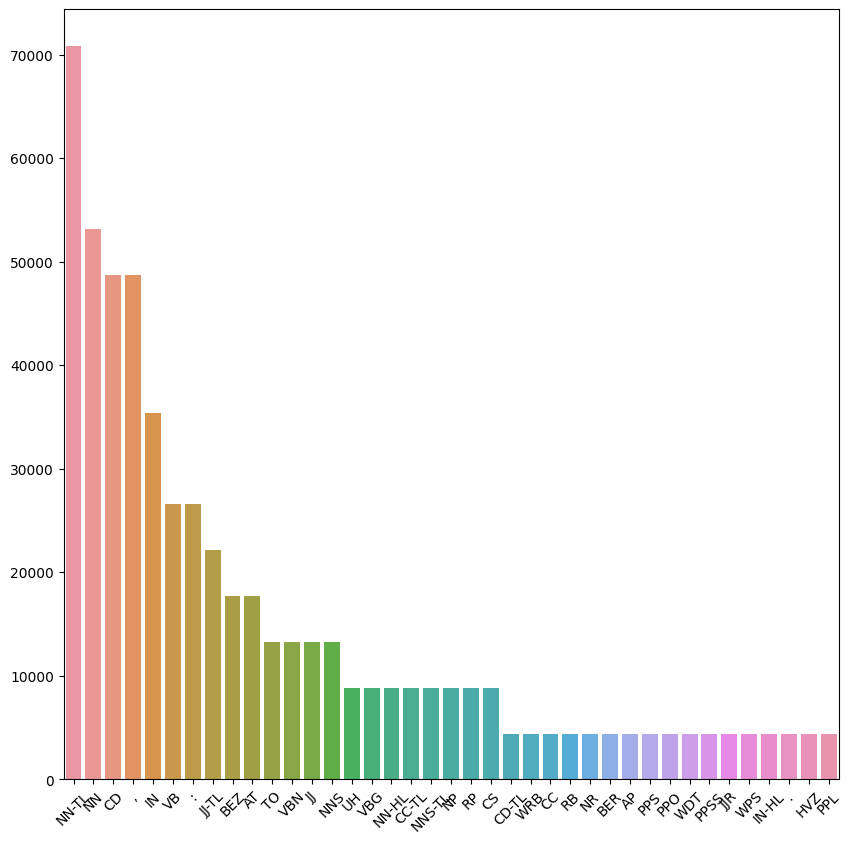

In [ ]:
fd_most_common =  cctagFD.most_common()
fdmc = pd.Series(dict(fd_most_common))
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.barplot(x=fdmc.index, y=fdmc.values, ax=ax)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 [Text(0, 0, 'NN-TL'),
  Text(1, 0, 'NN'),
  Text(2, 0, 'CD'),
  Text(3, 0, ','),
  Text(4, 0, 'IN'),
  Text(5, 0, 'VB'),
  Text(6, 0, ':'),
  Text(7, 0, 'JJ-TL'),
  Text(8, 0, 'BEZ'),
  Text(9, 0, 'AT'),
  Text(10, 0, 'TO'),
  Text(11, 0, 'VBN'),
  Text(12, 0, 'JJ'),
  Text(13, 0, 'NNS'),
  Text(14, 0, 'UH'),
  Text(15, 0, 'VBG'),
  Text(16, 0, 'NN-HL'),
  Text(17, 0, 'CC-TL'),
  Text(18, 0, 'NNS-TL'),
  Text(19, 0, 'NP'),
  Text(20, 0, 'RP'),
  Text(21, 0, 'CS'),
  Text(22, 0, 'CD-TL'),
  Text(23, 0, 'WRB'),
  Text(24, 0, 'CC'),
  Text(25, 0, 'RB'),
  Text(26, 0, 'NR'),
  Text(27, 0, 'BER'),
  Text(28, 0, 'AP'),
  Text(29, 0, 'PPS'),
  Text(30, 0, 'PPO'),
  Text(31, 0, 'WDT'),
  Text(32, 0, 'PPSS'),
  Text(33, 0, 'JJR'),
  Text(34, 0, 'WPS'),
  Text(35, 0, 'IN-HL'),
  Text(36, 0, '.'),
  Text(37, 0, 'HVZ'

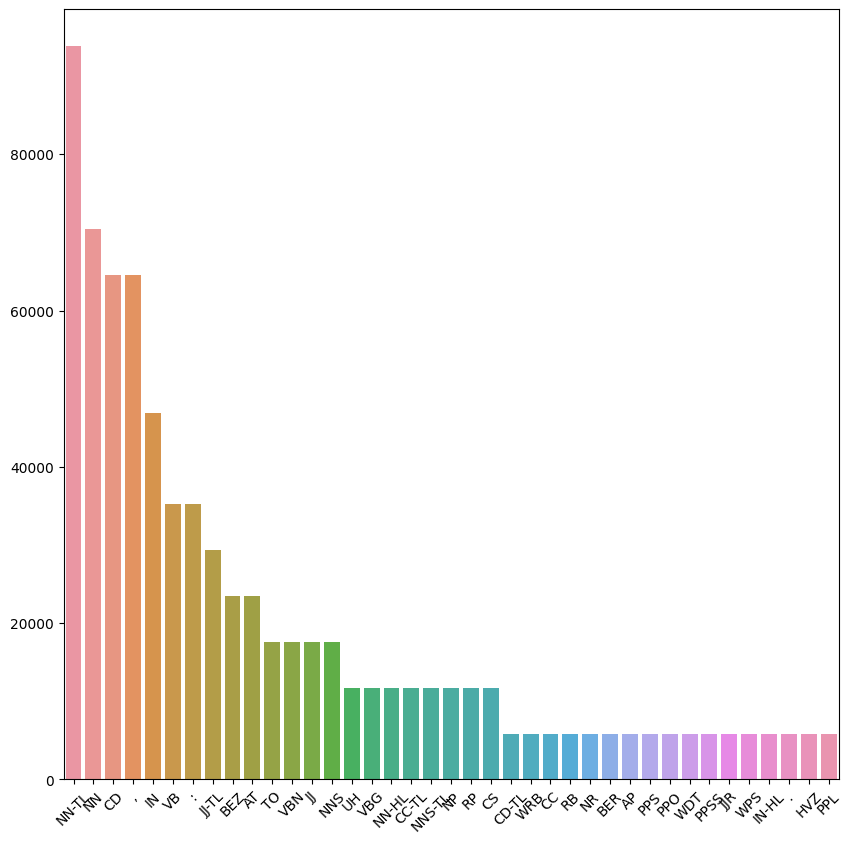

In [ ]:
notClicked = full_clean[full_clean['clicked']==0]
notClicked = notClicked.reset_index(drop=True)
nctagFD = nltk.FreqDist()
for row in notClicked['tags']:
  for word, tag in row:
    nctagFD[tag] +=1
nctagFD.most_common()
nctagFD.pop('default')
fd_most_common =  nctagFD.most_common()
fdmc = pd.Series(dict(fd_most_common))
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.barplot(x=fdmc.index, y=fdmc.values, ax=ax)
plt.xticks(rotation=45)

In [ ]:
## Tryin new features

In [ ]:
# ! pip install lingfeat